# LINATE Quickstart Tutorial

LINATE stands for "Language-Independent Network ATtitudinal Embedding". As its name suggests, it's a module for embedding social networks (graphs) in attitudinal spaces. Attitudinal spaces are geometrical opinion spaces where dimensions act as indicators of positive or negative opinions (i.e., attitudes) towards identifiable attitudinal objects (e.g., ideological positions such as left- or right-wing ideologies, or policy positions such as increasing tax redistribution, or increasing environmental protection).

This module provides tools for two methods: 

1) Ideological embedding: producing a graph embedding in an latent ideological space, where dimensions don't have explicit meaning, but are related to an homophilic model underlying the choises of users forming the graph.

2) Attitudinal embedding: mapping this embedded graph onto a second space that does have explicit meaning for its dimensions. For this, the module uses the position of some reference points that have known positions in both spaces.

Check our publication for further details:

Ramaciotti Morales, Pedro ,Jean-Philippe Cointet, Gabriel Muñoz Zolotoochin, Antonio Fernández Peralta, Gerardo Iñiguez, and Armin Pournaki. "Inferring Attitudinal Spaces in Social Networks." (2022).
https://hal.archives-ouvertes.fr/hal-03573188/document


## Embedding a bipartite graph in latent its ideological space

In [1]:
import pandas as pd
from linate import IdeologicalEmbedding

We load a bipartite social graph of reference users $i$ being followed (on Twitter) by users $j$. Each row must be an edge, i.e., a comma separated pair of node names. In this example, nodes $i$ are French parliamentarians on Twitter, and $j$ are their followers.

In [2]:
bipartite = pd.read_csv('bipartite_graph.csv',dtype=str)
print('columns :'+str(bipartite.columns))
print('edges: '+str(bipartite.shape[0]))
print('num. of reference nodes i: '+ str(bipartite['i'].nunique()))
print('num. of follower nodes j: '+ str(bipartite['j'].nunique()))

columns :Index(['i', 'j'], dtype='object')
edges: 1786372
num. of reference nodes i: 691
num. of follower nodes j: 306644


We load the model, choosing the number of latent dimensions of the embedding, and the number of neighbohrs that a users $j$ must have to be kept in the bipartite graph (we normally want users that have made enough choices).

In [3]:
ideoembedding_model = IdeologicalEmbedding(n_latent_dimensions = 2,in_degree_threshold = 3)

Using Ideological Embedding engine 'prince'.


LINATE works with directed graphs because it models networks as social choices: who chooses to connect or follow whom. Thus, we need to specify the direction of edges, which nodes are the source (those that chose) and which ones are the target (those that are chosen).

Note: there are different available "engines" that you should look out depending on how much memory you have on your machine. 

In [4]:
bipartite.rename(columns={'i':'target','j':'source'},inplace=True)
bipartite

,target,source
0,645,108730
1,343,100259
2,659,63349
3,328,45266
4,182,40626
...,...,...
1786367,164,150817
1786368,94,129139
1786369,89,135913
1786370,164,257283


Alternatively, you can use the provided data loader.

In [6]:
bipartite = ideoembedding_model.load_input_from_file(
    'bipartite_graph.csv',
    header_names={'target':'i','source':'j'})

Network loaded.


In [7]:
ideoembedding_model.fit(bipartite)

Bipartite network: False
Computing Ideological Embedding... done.


IdeologicalEmbedding(in_degree_threshold=3)

Once the ideological model is computed, we can retrieve the coordinates of the target nodes in the selected number of dimensions...

In [8]:
target_coords = ideoembedding_model.ideological_embedding_target_latent_dimensions_
target_coords

,latent_dimension_0,latent_dimension_1
target_id,,
645,0.837963,0.862132
343,0.888378,0.790544
659,0.874285,0.751741
328,0.544884,0.504877
182,0.565321,-0.144259
...,...,...
184,1.059064,0.330465
35,1.040288,0.233440
761,0.784578,0.769968


... and the coordinates of the followers.

In [9]:
source_coords = ideoembedding_model.ideological_embedding_source_latent_dimensions_
source_coords

,latent_dimension_0,latent_dimension_1
source_id,,
108730,0.107242,0.550253
307685,0.790634,1.109493
297595,0.700424,0.587862
4117,0.721815,0.922977
21901,1.055949,0.970085
...,...,...
256106,1.318862,0.383285
256109,1.318862,0.383285
42777,1.294079,0.251033


Reference users often come in groups, which is helpful for interpreting what dimensions are capturing. For this, we need a file identifying each reference users $i$ with a group $k$. In our example, parliamentarians belong to parties.

In [10]:
df_ref_group=pd.read_csv('reference_group.csv', dtype=str)
df_ref_group

,i,k
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
822,822,9
823,823,9
824,824,9
825,825,9


Let's plot the ideological positions of references, followers, and groups. To plot users and groups, we attribute groups to target users:

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
color_dic = {'0':'blue','1':'red','2':'gold','3':'orange','4':'green',
             '5':'violet','6':'cyan','7':'magenta','8':'brown','9':'gray'}

In [12]:
target_coords['k'] = target_coords.index.map(df_ref_group.set_index('i')['k'])

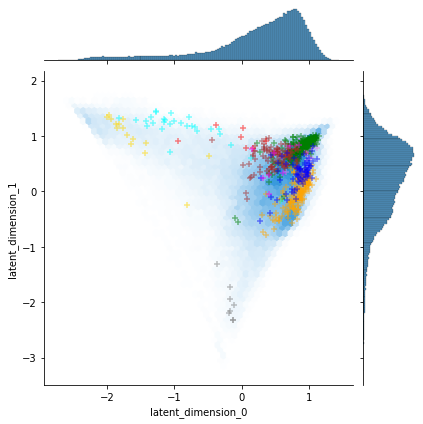

In [13]:
g = sn.jointplot(data=source_coords.drop_duplicates(),x='latent_dimension_0',y='latent_dimension_1',kind="hex")
ax=g.ax_joint
for k in target_coords['k'].unique():
    df_k = target_coords[target_coords['k']==k]
    ax.scatter(df_k['latent_dimension_0'],df_k['latent_dimension_1'],
               marker='+',s=30,alpha=0.5,color=color_dic[k])

## Embedding a bipartite graph in an attitudinal reference space

To embed map the network onto a space with explicit meanings for dimensions, we need reference points, such as the positions of parties for some issues.

In [14]:
group_attitudes = pd.read_csv('group_attitudes.csv')
group_attitudes['k'] = group_attitudes['k'].astype(str)
group_attitudes

,k,issue_1,issue_2
0,1,2.875000,4.285714
1,2,0.875000,9.571428
2,3,8.125000,3.714286
3,4,6.333334,5.000000
4,5,6.250000,3.666667
5,6,1.125000,6.857143
6,8,3.125000,3.857143
7,9,6.875000,9.428572


Because we know the positions of targets and their groups, we can compute group positions as means.

In [15]:
group_ideologies = target_coords.groupby('k').mean()
group_ideologies

,latent_dimension_0,latent_dimension_1
k,,
0,0.830639,0.311642
1,-0.104247,0.956746
2,-1.606626,0.986588
3,0.826658,-0.009683
4,0.888845,0.799158
5,0.932746,0.707684
6,-0.908047,1.137756
7,0.491547,0.490506
8,0.499216,0.606797


Text(0.5, 1.0, 'Group positions in attitudinal space')

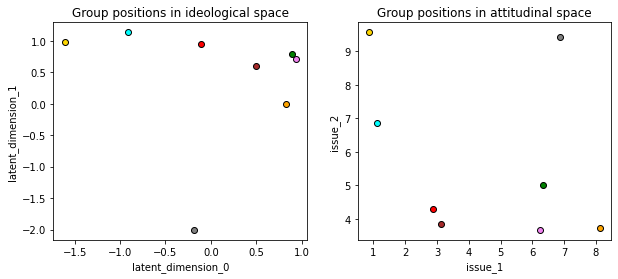

In [16]:
fig = plt.figure(figsize=(10,4))# width, height inches
ax = {1:fig.add_subplot(1,2,1),2:fig.add_subplot(1,2,2)}
for k,row in group_ideologies[group_ideologies.index.isin(group_attitudes['k'])].iterrows():
    ax[1].plot(row['latent_dimension_0'],row['latent_dimension_1'],'o',mec='k',color=color_dic[k])
ax[1].set_xlabel('latent_dimension_0'),ax[1].set_ylabel('latent_dimension_1')
ax[1].set_title('Group positions in ideological space')
for k,row in group_attitudes.iterrows():
    ax[2].plot(row['issue_1'],row['issue_2'],'o',mec='k',color=color_dic[row['k']])
ax[2].set_xlabel('issue_1'),ax[2].set_ylabel('issue_2')
ax[2].set_title('Group positions in attitudinal space')

In [17]:
from linate import AttitudinalEmbedding
attiembedding_model = AttitudinalEmbedding(N = 2)

We need a DataFrame containing the latent coordinates, but also name of the nodes:

In [18]:
target_coords['entity'] = target_coords.index 
target_coords

,latent_dimension_0,latent_dimension_1,k,entity
target_id,,,,
645,0.837963,0.862132,5,645
343,0.888378,0.790544,4,343
659,0.874285,0.751741,5,659
328,0.544884,0.504877,4,328
182,0.565321,-0.144259,3,182
...,...,...,...,...
184,1.059064,0.330465,3,184
35,1.040288,0.233440,0,35
761,0.784578,0.769968,8,761


In [19]:
X = attiembedding_model.convert_to_group_ideological_embedding(target_coords, df_ref_group.rename(columns={'i':'entity','k':'group'}))
X

,entity,latent_dimension_0,latent_dimension_1
0,0,0.830639,0.311642
1,1,-0.104247,0.956746
2,2,-1.606626,0.986588
3,3,0.826658,-0.009683
4,4,0.888845,0.799158
5,5,0.932746,0.707684
6,6,-0.908047,1.137756
7,7,0.491547,0.490506
8,8,0.499216,0.606797
9,9,-0.182970,-2.006722


In [20]:
Y = group_attitudes.rename(columns={'k':'entity'})

Using positions of groups, we can compute a map between ideological and attitudinal space.

In [21]:
attiembedding_model.fit(X, Y)

Groups:  ['1' '2' '3' '4' '5' '6' '8' '9']
Y columns:  3 Index(['entity', 'issue_1', 'issue_2'], dtype='object')
Number of political parties:  8


AttitudinalEmbedding(N=2)

If we provide our target coordinates with an entity column, we can transform their coordinates to attitudinal space.

In [22]:
target_coords['entity'] = target_coords.index
target_attitudinal = attiembedding_model.transform(target_coords)
target_attitudinal

,entity,issue_1,issue_2
0,645,5.557009,3.401628
1,343,5.762221,3.371741
2,659,5.783330,3.451144
3,328,5.395974,4.509674
4,182,6.306557,5.246663
...,...,...,...
686,184,6.747475,3.533548
687,35,6.836078,3.694093
688,761,5.563818,3.636186
689,744,6.140177,3.989638


Similarly, for source nodes:

In [23]:
source_coords['entity'] = source_coords.index
source_attitudinal = attiembedding_model.transform(source_coords)
source_attitudinal

,entity,issue_1,issue_2
0,108730,4.383179,5.465011
1,307685,5.123982,3.212059
2,297595,5.623687,4.050412
3,4117,5.223101,3.596217
4,21901,5.887279,2.768070
...,...,...,...
305960,256106,7.242288,2.870083
305961,256109,7.242288,2.870083
305962,42777,7.364822,3.087048
305963,27665,7.364822,3.087048


And if we put again the groups of each target user, we can compute party positions according to the social network, and plot all nodes and groups in attitudinal space.

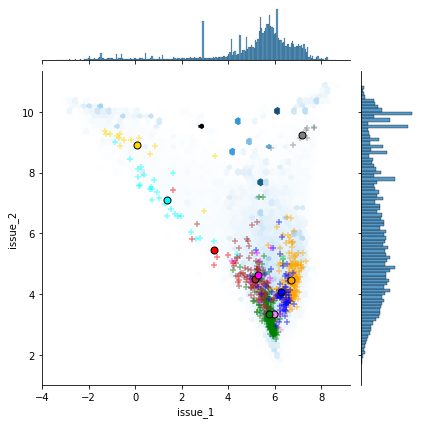

In [24]:
target_attitudinal['k'] = target_attitudinal['entity'].map(pd.Series(index=df_ref_group['i'].values,data=df_ref_group['k'].values))

g = sn.jointplot(data=source_attitudinal.drop_duplicates(),x='issue_1',y='issue_2',kind="hex")
ax=g.ax_joint
for k in target_attitudinal['k'].unique():
    df_k = target_attitudinal[target_attitudinal['k']==k]
    df_k_mean = df_k[['issue_1','issue_2']].mean()
    ax.scatter(df_k['issue_1'],df_k['issue_2'],marker='+',s=30,alpha=0.5,color=color_dic[k])
    ax.plot(df_k_mean['issue_1'],df_k_mean['issue_2'],'o',mec='k',color=color_dic[k],ms=7)